In [35]:
import pandas as pd
import numpy as np
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, Subset
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Path to the directory containing the plant folders
base_dir = 'PlantVillage'

# Initialize an empty dictionary to store counts of healthy and diseased images for each plant type
plant_counts = {}

# Initialize a list to store the class labels
labels = []

# Loop through each folder in the base directory
for folder_name in os.listdir(base_dir):
    labels.append(folder_name)
    folder_path = os.path.join(base_dir, folder_name)
    
    # Ensure it's a directory
    if os.path.isdir(folder_path):
        # Split the folder name to get the plant type and health status
        parts = folder_name.split('_')
        plant_type = parts[0]
        health_status = parts[1]
        
        # Initialize the dictionary entry if it doesn't exist
        if plant_type not in plant_counts:
            plant_counts[plant_type] = [0, 0]  # [healthy, diseased]
        
        # Recursively count files in the folder and any subfolders
        num_files = sum([len(files) for _, _, files in os.walk(folder_path)])
        
        # Update the count based on the health status
        if health_status == 'healthy':
            plant_counts[plant_type][0] += num_files
        else:
            plant_counts[plant_type][1] += num_files

print("Healthy vs Diseased Image Count per plant: \n", plant_counts)

Healthy vs Diseased Image Count per plant: 
 {'Tomato': [1591, 14421], 'Potato': [152, 2000], 'BellPepper': [1478, 997]}


In [4]:
# Define image transformations for the training and validation datasets
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                       
                                      ])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
# Load the full dataset and get the label for each image based on the directory name
data_dir = 'PlantVillage'
full_dataset = ImageFolder(root=data_dir)
labels = [sample[1] for sample in full_dataset.samples]

# Create a stratified train-test split with 20% being used for test data.
train_idx, val_idx = train_test_split(range(len(labels)), test_size=0.2, stratify=labels, random_state=42)
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

# Calculate the class distribution in the training set
train_labels = [labels[i] for i in train_idx]
unique_labels = set(train_labels)
print("Unique labels in training set:", unique_labels)  # This should show indices from 0 to 14

class_counts = np.bincount(train_labels)

# Calculate class weights
class_weights = 1.0 / class_counts
class_weights[np.isinf(class_weights)] = 0.0  # Handle potential infinities
class_weights /= np.sum(class_weights)  # Normalize

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Calculate sample weights for the training set only
sample_weights = [class_weights_tensor[label].item() for label in train_labels]  # Use train_labels for correct indexing

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Apply the transforms to the datasets
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

# Create DataLoaders with the sampler for training and regular DataLoader for validation
# train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Unique labels in training set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [43]:
# Import the Resnet model for transfer learning
model = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT )
# Freeze the parameters in the base model so only the new layers are being updated
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_classes = len(class_counts)

if model.__class__.__name__ == "VisionTransformer":
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

    # Unfreeze the final layer to allow it to learn during training
    for param in model.heads.head.parameters():
        param.requires_grad = True

else:
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace the last layer

# Move the model to the desired device (e.g., 'cuda' or 'cpu')
model = model.to(device)

In [44]:
# Initialize the loss function with the class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Set up the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs for training
num_epochs = 5

# Store the model with the best performance on training for use on the validation set
best_train_loss = float('inf')
best_model_path = "best_model.pth"  # Path to save the best model based on training loss

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:  # Iterate over DataLoader
        images, labels = images.to(device), labels.to(device)  # Move to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)  # Calculate loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Save the model if it has the lowest training loss
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with training loss: {best_train_loss:.4f}")

Epoch [1/5], Training Loss: 0.5741
New best model saved with training loss: 0.5741
Epoch [2/5], Training Loss: 0.2020
New best model saved with training loss: 0.2020
Epoch [3/5], Training Loss: 0.1404
New best model saved with training loss: 0.1404
Epoch [4/5], Training Loss: 0.1090
New best model saved with training loss: 0.1090
Epoch [5/5], Training Loss: 0.0891
New best model saved with training loss: 0.0891


In [45]:
# Load the best model weights before validation
model.load_state_dict(torch.load(best_model_path))
print("Loaded best model weights for validation.")

# Validation loop
model.eval()
val_loss = 0.0
correct = 0
total = 0

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Get predictions and actual labels
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        # Calculate accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

/tmp/ipykernel_18365/1544153863.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Loaded best model weights for validation.


Validation Loss: 0.1139 
Accuracy: 96.90%
Precision: 0.9693 
Recall: 0.9690 
F1 Score: 0.9688


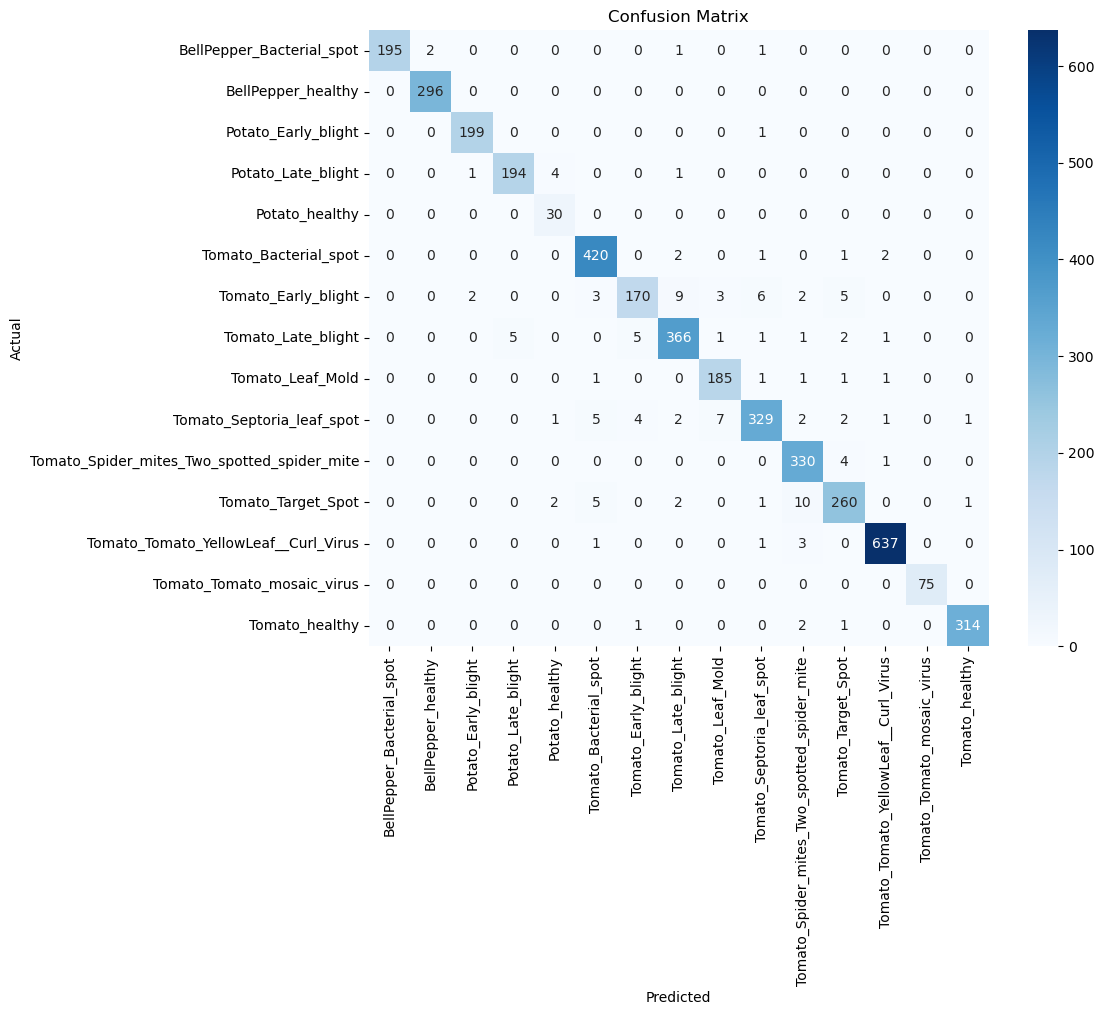

In [46]:
# Adding metrics of interest
avg_val_loss = val_loss / len(val_loader)
accuracy = 100 * correct / total
print(f"Validation Loss: {avg_val_loss:.4f} \nAccuracy: {accuracy:.2f}%")

# Calculate precision, F1 score, and confusion matrix
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Precision: {precision:.4f} \nRecall: {recall:.4f} \nF1 Score: {f1:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()